In [2]:
!pip install fastai

In [3]:
!pip install fastai2

     |████████████████████████████████| 184kB 8.2MB/s 


In [4]:
!pip install fastcore

In [5]:
import pandas as pd
import numpy as np
import collections
from collections import Counter
from fastai2.text.all import *
import sklearn.metrics

/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla T4 with CUDA capability sm_75 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the Tesla T4 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


In [6]:
def get_metrics(preds,predictions, true_vals):

    f1_w = sklearn.metrics.f1_score(true_vals, preds, average='weighted')
    f1 = sklearn.metrics.f1_score(true_vals, preds, average=None)
    acc = sklearn.metrics.accuracy_score(true_vals, preds)
    prec = sklearn.metrics.precision_score(true_vals,preds, average=None) 
    rec = sklearn.metrics.recall_score(true_vals,preds, average=None)
    auroc = sklearn.metrics.roc_auc_score(true_vals,predictions[:,1], average=None)
    confusion = sklearn.metrics.confusion_matrix(true_vals, preds)

    tn, fn, fp, tp = confusion[1,1], confusion[1,0], confusion[0,1], confusion[0,0]

    sens = tp/(tp + fn)
    spec = tn/(tn + fp)
    ppv = tp/(tp + fp)
    npv = tn/(tn + fn)

    print ('Metrics Report:')
    print ('---------------')
    print ('weighted f1: ', f1_w)
    print ('AUROC:       ',auroc)
    print ('accuracy:    ', acc)
    print ('precision:   ', prec)
    print ('recall:      ', rec)
    print ('sensitivity: ', sens)
    print ('specificity: ', spec)
    print ('PPV:         ', ppv)
    print ('NPV:         ', npv)
    print ()
    print ('confusion matrix')
    print (confusion)

    results_df.loc[len(results_df)] = [desc,num_samples, weights, f1_w, acc, auroc, ppv, sens, batch_size]

In [8]:
def encode_data(df, text_field):
    encoded_data_train = tokenizer.batch_encode_plus(
        df[df.data_type=='train'][text_field].values, 
        add_special_tokens=True, 
        return_attention_mask=True, 
        pad_to_max_length=True, 
        max_length=256, 
        return_tensors='pt'
        )

    encoded_data_val = tokenizer.batch_encode_plus(
        df[df.data_type=='val'][text_field].values, 
        add_special_tokens=True, 
        return_attention_mask=True, 
        pad_to_max_length=True, 
        max_length=256, 
        return_tensors='pt'
        )


    input_ids_train = encoded_data_train['input_ids']
    attention_masks_train = encoded_data_train['attention_mask']
    labels_train = torch.tensor(df[df.data_type=='train'].label.values)

    input_ids_val = encoded_data_val['input_ids']
    attention_masks_val = encoded_data_val['attention_mask']
    labels_val = torch.tensor(df[df.data_type=='val'].label.values)

    return input_ids_train, attention_masks_train, labels_train, input_ids_val, attention_masks_val, labels_val



def create_dataloaders(input_ids_train, attention_masks_train, labels_train, input_ids_val, attention_masks_val, labels_val, batch_size = 32):
    dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
    dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

    dataloader_train = DataLoader(dataset_train, 
                              #sampler=RandomSampler(dataset_train), 
                              sampler=ImbalancedDatasetSampler(dataset_train, callback_get_label = get_label_cb),
                              batch_size=batch_size)

    dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)
  
    return dataloader_train, dataloader_validation

def process_data(data):
    df = data.sample(num_samples)
    df.discharge.value_counts()
    label_dict = {'discharge':0, 'admit':1}; label_dict
    df['label'] = df.discharge.replace(label_dict)
    df['text'] = df['CleanSubjectiveNotes'].map(str) + ', ' + df['pmhx'].map(str)
    df = df[['discharge', 'label', 'text']]
    display(df.head())
    
    return df, label_dict


def split_data(df, test_size=0.1):
    X_train, X_val, y_train, y_val = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size=test_size, 
                                                  random_state=17, 
                                                  stratify=df.label.values)
    
    # this field is done for creating a balanced training portion of the dataset
    #pos_training_examples = [[x[0],x[1]] for x in list(zip(X_train, y_train)) if x[1] == 1]
    #neg_training_examples = [[x[0], x[1]] for x in list(zip(X_train, y_train)) if x[1] == 0]
    #neg_train_subset = random.sample(list(neg_training_examples), len(pos_training_examples))
    #new_train_set = pos_training_examples + neg_train_subset
    #X_train = np.array(new_train_set)[:,0]
    #y_train = np.array(new_train_set)[:,1]
    
    
    df['data_type'] = ['not_set']*df.shape[0]
    df.loc[X_train, 'data_type'] = 'train'
    df.loc[X_val, 'data_type'] = 'val'
    #df = df[df['data_type'] != 'not set']  #new 
    
    display(df.groupby(['discharge', 'label', 'data_type']).count())
    
    return X_train, X_val, y_train, y_val

In [9]:
#set directories
data_dir = '/content/drive/My Drive/machine_learning/ed_triage/'
model_dir = '/content/drive/My Drive/ML_data/models/'

In [10]:
#loads result dataframe or initializes an empty one
try:
    results_df = pd.read_csv(data_dir + 'results.csv', index_col = 0)
except:
    results_df = pd.DataFrame(columns = ['experiment description', 'num samples', 'weighting', 'f1w', 'acc', 'auroc', 'ppv', 'sens', 'batch size'])

results_df.index = list(range(len(results_df)))   #to clean the index 
results_df

,experiment description,num samples,weighting,f1w,acc,auroc,ppv,sens,batch size
0,tiny test dataset,1000,NaN,0.831008,0.885000,0.558339,0.000000,NaN,32
1,"larger test dataset, only subj notes",10000,NaN,0.854283,0.899500,0.780036,0.010000,0.400000,32
2,"larger test dataset, only subj notes",50000,NaN,0.876438,0.896900,0.795039,0.178138,0.445570,32
3,"larger test dataset, only subj notes",100000,NaN,0.876970,0.901000,0.807763,0.155172,0.493548,32
4,"50k repr samples, both nlp fields",50000,NaN,0.881214,0.895400,0.798594,0.237219,0.436090,16
5,"weighted loss, both nlp fields",50000,"{'discharge': 8, 'admit': 1}",0.865623,0.901200,0.808986,0.070281,0.530303,16
6,"first try lamb, both nlp fields",10000,NaN,0.876643,0.895000,0.788044,0.200000,0.444444,16
7,"mixed prec, adults only, lamb",100000,NaN,0.877511,0.890000,0.824240,0.276190,0.460317,32
8,"mixed prec, bch only, lamb",102128,NaN,0.885827,0.900519,0.802072,0.233230,0.452906,64
9,"mixed prec, bch only, lamb",50000,NaN,0.859869,0.905000,0.500000,0.000000,NaN,16


In [11]:
data = pd.read_csv(data_dir + 'nlp_combo_data.csv', index_col = 0)

In [13]:
data.head()

,CleanSubjectiveNotes,pmhx,num_comorbids,outcome,target,service,target2,discharge,target3,dispo,target4,ICUvsother,target5,site
0,patient states that she feels shaky patient denies any pain,no significant medical history,0,discharge,1,discharge,1,discharge,1,NaN,NaN,NaN,0,BCH
1,patient states no pain,no significant medical history,0,discharge,1,discharge,1,discharge,1,NaN,NaN,NaN,0,BCH
2,denied chest pain,no significant medical history,0,discharge,1,discharge,1,discharge,1,NaN,NaN,NaN,0,BCH
3,denies pain eating emergency department lunch at triage,"dialysis haemo, type one diabetes, chronic renal failure, heart problem, high cholesterol",5,discharge,1,discharge,1,discharge,1,NaN,NaN,NaN,0,BCH
4,patient complains of pain on the left wrist and left ankle no obvious deformity with minor laceration in between left thumb and 2nd digit left finger,fibromyalgia,1,discharge,1,discharge,1,discharge,1,NaN,NaN,NaN,0,BCH


In [14]:
len(data)

165268

In [15]:
num_samples = 165268
df, label_dict = process_data(data)

,discharge,label,text
86125,discharge,0,"patient does heavy lifting at work yesterday while at work felt sudden pain to right upper back pain took advil for same no releif patient denies any fall, no significant medical history, no significant medical history"
16376,admit,1,"diarrhea multiple times from yesterday no vomiting voiding well complains of abdominal pain discharge from hospital on 30 may, hypertension, heart, stroke, type two diabetes, high cholesterol, stents"
50147,discharge,0,"gout to left great toe pain having pain since last saturday morning , no significant medical history"
163273,discharge,0,"neck pain for 3 days radiating to the head neck feels stiff no fever no cough seen by family physician given naproxen but not helping states feels heaviness in eyes and head complains of nausea but no vomiting, no significant medical history"
81606,discharge,0,"as per mom child has been having fever since thursday that has been treating alternating with tylenol and advil temp as high as 103 sore throat that started on friday and squeaking when crying mom also states that child was twitching a little last night and more lethargic that usual decrease intake and voiding less than normal change 3 diaper this morning immunization up to date , no significant medical history"


In [16]:
dls_lm = TextDataLoaders.from_df(df, text_col = 2, label_col =0, is_lm = True, valid_pct = 0.1, seq_len = 96, bs = 64)

In [17]:
dls_lm.show_batch(max_n=5)

,text,text_
0,"xxbos patient woke up with palpitations 20 minutes ago reporting slight mid sternal chest pain and shortness of breath feels bit dizzy and nauseous no vomiting was seen by family doctor yesterday ecg done and was normal had similar episodes 3 months ago was investigated and told everything is normal , palpitations xxbos patient had vaginal delivery on feb 7th and was seen in emergency room for headache and nausea a on wednesday went to family doctor today and protein was detected in her urine complains of discomfort to urq of abdomen patient continue to have","patient woke up with palpitations 20 minutes ago reporting slight mid sternal chest pain and shortness of breath feels bit dizzy and nauseous no vomiting was seen by family doctor yesterday ecg done and was normal had similar episodes 3 months ago was investigated and told everything is normal , palpitations xxbos patient had vaginal delivery on feb 7th and was seen in emergency room for headache and nausea a on wednesday went to family doctor today and protein was detected in her urine complains of discomfort to urq of abdomen patient continue to have post"
1,"taking a prescription tylenol with null relief last dose was taken about 3 hours ago also complains of onset of headache since yesterday patient states he had radiation april for tumor at the back of the right eye complains of headache at present , breast cancer , head tumor xxbos patient fell this morning onto left hand patient states shooting pain to fingers unable to move 3rd and 4th digit bruising to middle of hand , sleep apnea , hypothyroid xxbos patient was seen in emergency room sunday morning for shortness of breath patient was asked","a prescription tylenol with null relief last dose was taken about 3 hours ago also complains of onset of headache since yesterday patient states he had radiation april for tumor at the back of the right eye complains of headache at present , breast cancer , head tumor xxbos patient fell this morning onto left hand patient states shooting pain to fingers unable to move 3rd and 4th digit bruising to middle of hand , sleep apnea , hypothyroid xxbos patient was seen in emergency room sunday morning for shortness of breath patient was asked to"
2,"0700 complains of nausea loose stool x1 yesterday fever and cough since friday last menstrual period sept 6 12 denies urinary tract infection complaints , no significant medical history xxbos patient was playing soccer yesterday and fell complains of pain to right knee since then states swelling to knee ambulating with cane able to wiggle toes swelling noted to knee decrease rom to knee , no significant medical history xxbos complains of headache and body pain , no significant medical history xxbos patient 9 weeks gestation g1p0 having spotting x 2 days denies pain vomitting feels","complains of nausea loose stool x1 yesterday fever and cough since friday last menstrual period sept 6 12 denies urinary tract infection complaints , no significant medical history xxbos patient was playing soccer yesterday and fell complains of pain to right knee since then states swelling to knee ambulating with cane able to wiggle toes swelling noted to knee decrease rom to knee , no significant medical history xxbos complains of headache and body pain , no significant medical history xxbos patient 9 weeks gestation g1p0 having spotting x 2 days denies pain vomitting feels constipated"
3,"last menstrual period 1 wk ago was heavy as well patient has good colour , low blood pressure xxbos chest pain shortness of breath and cough with green phlegm , spinal cord injury , emphysema , chronic obstructive pulmonary , indwelling catheter xxbos patient complains of intermittent left groin pain radiates down left leg x approx 6 weeks pain is now constant x 1 week and is more severe patient states she is dizzy at times normal voiding / bowel movements states last menstrual period was lighter and shorter in duration than normal and has noticed","menst

In [18]:
learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], wd=0.1).to_fp16()

In [19]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.739125,3.360719,0.354971,28.809904,04:38


/usr/local/lib/python3.6/dist-packages/fastai2/callback/schedule.py:68: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx = (pos >= pcts).nonzero().max()


In [20]:
learn.save('1epoch')

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.444212,3.165545,0.377296,23.701658,05:03
1,3.265207,3.017130,0.395537,20.432570,05:04


In [ ]:
encoder = get_model(learn)[0]
if hasattr(encoder, 'module'): encoder = encoder.module
torch.save(encoder.state_dict(), model_dir + 'fastaiv2enc.pth')

In [ ]:
learn.save_encoder('finetuned')

In [ ]:
dls_clas = TextDataLoaders.from_df(df, text_col = 2, label_col =0, text_vocab=dls_lm.vocab, seq_len = 128, bs = 32, valid_pct=0.1)

In [ ]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [ ]:
learn = learn.load_encoder('finetuned')

In [ ]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.394153,0.268434,0.901000,01:14


In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.258877,0.266017,0.901700,01:17


In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.247626,0.264263,0.902000,01:25


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.228082,0.269279,0.901900,01:39
1,0.216498,0.269656,0.900600,01:38


In [ ]:
learn.predict("hypertension tachycardia syncope chest pain sepsis admission")

('discharge', tensor(1), tensor([0.4076, 0.5924]))

In [ ]:
learn.save('fastaiv2all')

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

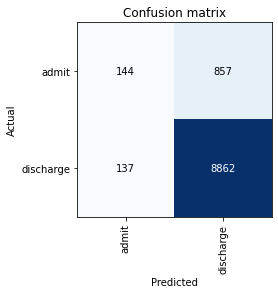

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
preds, targets = learn.get_preds() 
predictions = np.argmax(preds, axis = 1) 

In [ ]:
desc = 'restart fast ai v2'
weights = None
batch_size = 32

In [ ]:
get_metrics(predictions, preds, targets)

Metrics Report:
---------------
weighted f1:  0.8745991062020941
AUROC:        0.812331906342352
accuracy:     0.9006
precision:    [0.51245552 0.9118222 ]
recall:       [0.14385614 0.98477609]
sensitivity:  0.5124555160142349
specificity:  0.9118222039304456
PPV:          0.14385614385614387
NPV:          0.9847760862318036

confusion matrix
[[ 144  857]
 [ 137 8862]]


### trying with label smoothing

In [ ]:
loss_func = LabelSmoothingCrossEntropyFlat()

In [ ]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, loss_func = loss_func,  drop_mult=0.5, metrics=accuracy)

In [ ]:
learn = learn.load_encoder('finetuned')

In [ ]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.497525,0.369008,0.902400,01:14


In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.375404,0.368211,0.902500,01:18


In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.368871,0.365567,0.902600,01:27


In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.356636,0.367364,0.902400,01:38
1,0.348509,0.369049,0.902000,01:39


In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

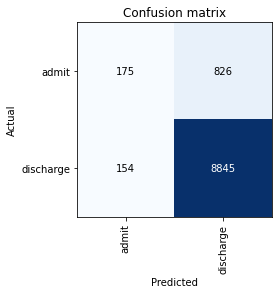

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
preds, targets = learn.get_preds() 
predictions = np.argmax(preds, axis = 1) 

In [ ]:
get_metrics(predictions, preds, targets)

Metrics Report:
---------------
weighted f1:  0.8790057903193977
AUROC:        0.8127985471579204
accuracy:     0.902
precision:    [0.53191489 0.91459001]
recall:       [0.17482517 0.98288699]
sensitivity:  0.5319148936170213
specificity:  0.9145900113742116
PPV:          0.17482517482517482
NPV:          0.9828869874430493

confusion matrix
[[ 175  826]
 [ 154 8845]]


In [ ]:
results_df.to_csv(data_dir + 'results.csv')